In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        pass
        # Implement this!
        action_value_list = Q[observation]
        optimal_action = np.argmax(action_value_list)
        action_prob_list = np.zeros(len(Q[observation]))
        action_prob_list[optimal_action] = 1

        return action_prob_list

    return policy_fn

In [27]:
target_policy = create_greedy_policy(Q)

In [28]:
target_policy

<function __main__.create_greedy_policy.<locals>.policy_fn(observation)>

In [29]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    # Implement this!
    for i in range(num_episodes):
        t=0
        episode_list = []
        state = env.reset()
        while True:
            # behavior policy에 따라 action을 수행
            action = np.random.choice(np.arange(env.action_space.n),p=behavior_policy(state))
            next_state, reward, done, _ = env.step(action)
            episode_list.append((state, action, reward))
            t+=1
            state = next_state
            if done or t == 100:
                break

        G = 0
        W = 1
        for step in range(len(episode_list)-1,-1,-1):
            state, action, reward = episode_list[step][0], episode_list[step][1], episode_list[step][2]
            # update return
            G = discount_factor * G + reward
            # for incremental weighted importance sampling, use C and W
            # C_n = W_1 + ... + W_n
            # W = importance ratio
            C[state][action] = C[state][action] + W
            # 분모가 0인 경우 Q를 0으로 업데이트
            if C[state][action]*(G-Q[state][action]) == 0:
                Q[state][action] = 0
            else: 
                Q[state][action] = Q[state][action] + W / C[state][action]*(G-Q[state][action])
            
            optimal_action = np.argmax(Q[state])
            target_policy = create_greedy_policy(Q)
            # greedy policy에 따른 action이 아닐 경우 다음 episode 학습으로 바로 건너뛰기
            if action != optimal_action:
                break
            W = W * target_policy(state)[action] / behavior_policy(state)[action]
            

    return Q, target_policy

In [30]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

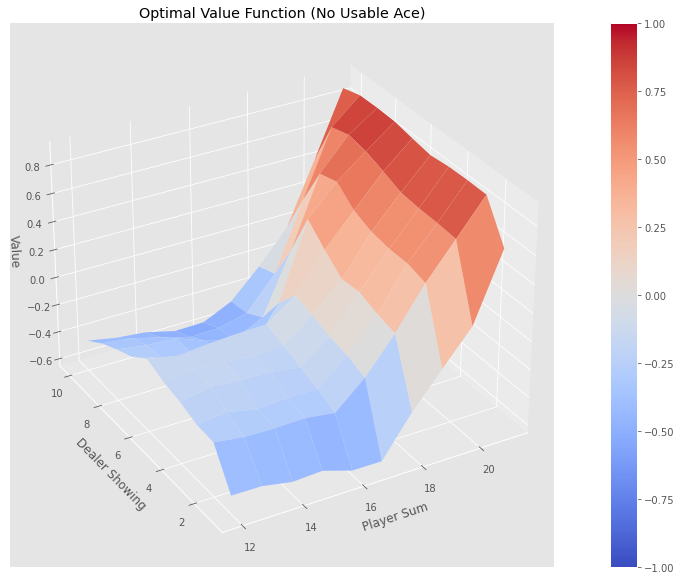

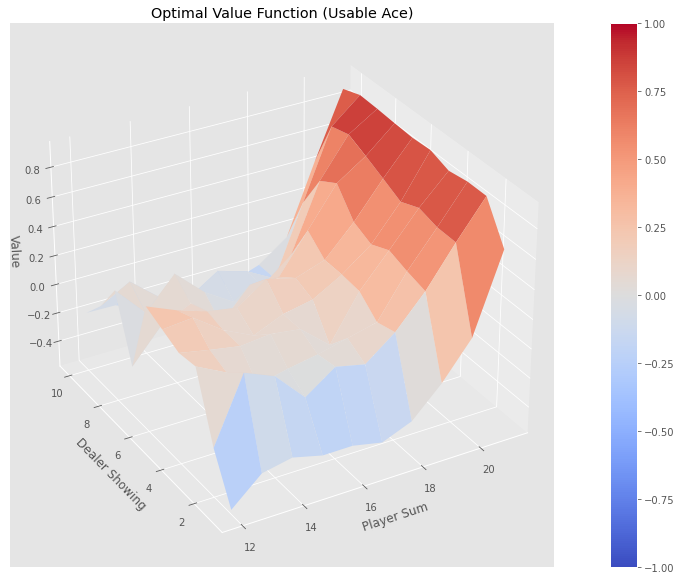

In [31]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")